# **DEPENDENCIES**

In [1]:
import numpy as np
import torch
import torch.nn as nn

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

# **DATASET**

In [2]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist
(Xtr, Ytr), (Xte, Yte) = mnist.load_data()

In [4]:
Xtr = Xtr.reshape(-1, 784)
Xte = Xte.reshape(-1, 784)
Ytr = np.eye(10)[Ytr]
Yte = np.eye(10)[Yte]

# Normalize
Xtr = Xtr / 255
Xte = Xte / 255

#### **Utils**

In [52]:
def plot_history(history, accu=False, title="Training vs Validation Loss"):
    plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    sns.set_style("darkgrid")
    sns.lineplot(
        x=range(1, len(history["loss"]) + 1),
        y=history["loss"],
        label="Training Loss",
    )
    sns.lineplot(
        x=range(1, len(history["val_loss"]) + 1),
        y=history["val_loss"],
        label="Validation Loss",
    )
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    if accu and "accuracy" in history and "val_accuracy" in history:
        plt.subplot(1, 2, 2)
        sns.set_style("darkgrid")
        sns.lineplot(
            x=range(1, len(history["accuracy"]) + 1),
            y=history["accuracy"],
            label="Training Accuracy",
        )
        sns.lineplot(
            x=range(1, len(history["val_accuracy"]) + 1),
            y=history["val_accuracy"],
            label="Validation Accuracy",
        )
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()

    plt.suptitle(title)
    plt.show()


def plot_images(
    original_images, reconstructed_images, title="Original vs Reconstructed Images"
):
    fig, axes = plt.subplots(2, 10, figsize=(16, 4))
    fig.suptitle(title)

    for i in range(10):
        axes[0, i].imshow(original_images[i].reshape(28, 28), cmap="gray")
        axes[0, i].axis("off")
        axes[1, i].imshow(reconstructed_images[i].reshape(28, 28), cmap="gray")
        axes[1, i].axis("off")

    plt.tight_layout()

    plt.show()

#### **Neural Network (scratch)**

In [12]:
class FeedForwardNet:
    def __init__(self, inp_units, hid_units, out_units):
        self.inp_units = inp_units
        self.hid_units = hid_units
        self.out_units = out_units

        # Parameters
        self.W1 = np.random.randn(self.inp_units, self.hid_units)
        self.b1 = np.random.randn(self.hid_units)
        self.W2 = np.random.randn(self.hid_units, self.out_units)
        self.b2 = np.random.randn(self.out_units)

    def _sigmoid(self, x):
        # Clip x values to prevent overflow
        x = np.clip(x, -500, 500)
        return 1 / (1 + np.exp(-x))

    def _sigmoid_prime(self, x):
        return self._sigmoid(x) * (1 - self._sigmoid(x))

    def _mse(self, y, y_hat):
        return np.square(y - y_hat).mean()

    def _mse_prime(self, y, y_hat):
        return 2 * (y_hat - y) / y.size

    def _accuracy(self, y, y_hat, threshold=0.5):
        return np.sum(y == (y_hat > threshold)) / y.size

    def _forward_h(self, x):
        return self._sigmoid(np.dot(x, self.W1) + self.b1)

    def _forward_o(self, x):
        return self._sigmoid(np.dot(x, self.W2) + self.b2)

    def _forward(self, x):
        return self._forward_o(self._forward_h(x))

    def _backward_o(self, x, y, y_hat):
        dL_dz = self._mse_prime(y, y_hat) * self._sigmoid_prime(y_hat)
        dL_dW = np.dot(self._forward_h(x).T, dL_dz)
        dL_db = np.sum(dL_dz, axis=0)
        return dL_dW, dL_db, dL_dz

    def _backward_h(self, x, dL_dz):
        dL_dW = np.dot(
            x.T, np.dot(dL_dz, self.W2.T) * self._sigmoid_prime(self._forward_h(x))
        )
        dL_db = np.sum(
            np.dot(dL_dz, self.W2.T) * self._sigmoid_prime(self._forward_h(x)),
            axis=0,
        )
        return dL_dW, dL_db

    def _backward(self, x, y, y_hat, learning_rate):
        dL_dW2, dL_db2, dL_dz2 = self._backward_o(x, y, y_hat)
        dL_dW1, dL_db1 = self._backward_h(x, dL_dz2)
        self.W1 -= learning_rate * dL_dW1 
        self.b1 -= learning_rate * dL_db1 
        self.W2 -= learning_rate * dL_dW2 
        self.b2 -= learning_rate * dL_db2 

    def train(self, x, y, x_val, y_val, batch_size=16, epochs=10, learning_rate=1e-3):
        history = {
            "loss": [],
            "val_loss": [],
            "accuracy": [],
            "val_accuracy": [],
        }
        for epoch in range(epochs):
            print(f"Epoch {epoch + 1}/{epochs}")
            for i in tqdm(range(0, x.shape[0], batch_size)):
                x_batch = x[i : i + batch_size]
                y_batch = y[i : i + batch_size]
                y_hat = self._forward(x_batch)
                self._backward(x_batch, y_batch, y_hat, learning_rate)
            y_hat = self._forward(x)
            y_val_hat = self._forward(x_val)
            history["loss"].append(self._mse(y, y_hat))
            history["val_loss"].append(self._mse(y_val, y_val_hat))
            history["accuracy"].append(self._accuracy(y, y_hat))
            history["val_accuracy"].append(self._accuracy(y_val, y_val_hat))
        return history

Epoch 1/25


100%|██████████| 3750/3750 [00:13<00:00, 275.69it/s]


Epoch 2/25


100%|██████████| 3750/3750 [00:14<00:00, 265.07it/s]


Epoch 3/25


100%|██████████| 3750/3750 [00:10<00:00, 366.23it/s]


Epoch 4/25


100%|██████████| 3750/3750 [00:08<00:00, 435.15it/s]


Epoch 5/25


100%|██████████| 3750/3750 [00:11<00:00, 329.35it/s]


Epoch 6/25


100%|██████████| 3750/3750 [00:11<00:00, 328.00it/s]


Epoch 7/25


100%|██████████| 3750/3750 [00:25<00:00, 149.64it/s]


Epoch 8/25


100%|██████████| 3750/3750 [00:13<00:00, 275.48it/s]


Epoch 9/25


100%|██████████| 3750/3750 [00:07<00:00, 524.82it/s]


Epoch 10/25


100%|██████████| 3750/3750 [00:07<00:00, 522.67it/s]


Epoch 11/25


100%|██████████| 3750/3750 [00:06<00:00, 582.60it/s]


Epoch 12/25


100%|██████████| 3750/3750 [00:06<00:00, 579.15it/s]


Epoch 13/25


100%|██████████| 3750/3750 [00:07<00:00, 476.10it/s]


Epoch 14/25


100%|██████████| 3750/3750 [00:08<00:00, 427.77it/s]


Epoch 15/25


100%|██████████| 3750/3750 [00:20<00:00, 183.43it/s]


Epoch 16/25


100%|██████████| 3750/3750 [00:13<00:00, 282.38it/s]


Epoch 17/25


100%|██████████| 3750/3750 [00:10<00:00, 370.77it/s]


Epoch 18/25


100%|██████████| 3750/3750 [00:13<00:00, 272.64it/s]


Epoch 19/25


100%|██████████| 3750/3750 [00:15<00:00, 240.01it/s]


Epoch 20/25


100%|██████████| 3750/3750 [00:09<00:00, 398.69it/s]


Epoch 21/25


100%|██████████| 3750/3750 [00:16<00:00, 229.09it/s]


Epoch 22/25


100%|██████████| 3750/3750 [00:14<00:00, 250.43it/s]


Epoch 23/25


100%|██████████| 3750/3750 [00:09<00:00, 376.57it/s]


Epoch 24/25


100%|██████████| 3750/3750 [00:10<00:00, 344.35it/s]


Epoch 25/25


100%|██████████| 3750/3750 [00:10<00:00, 367.16it/s]


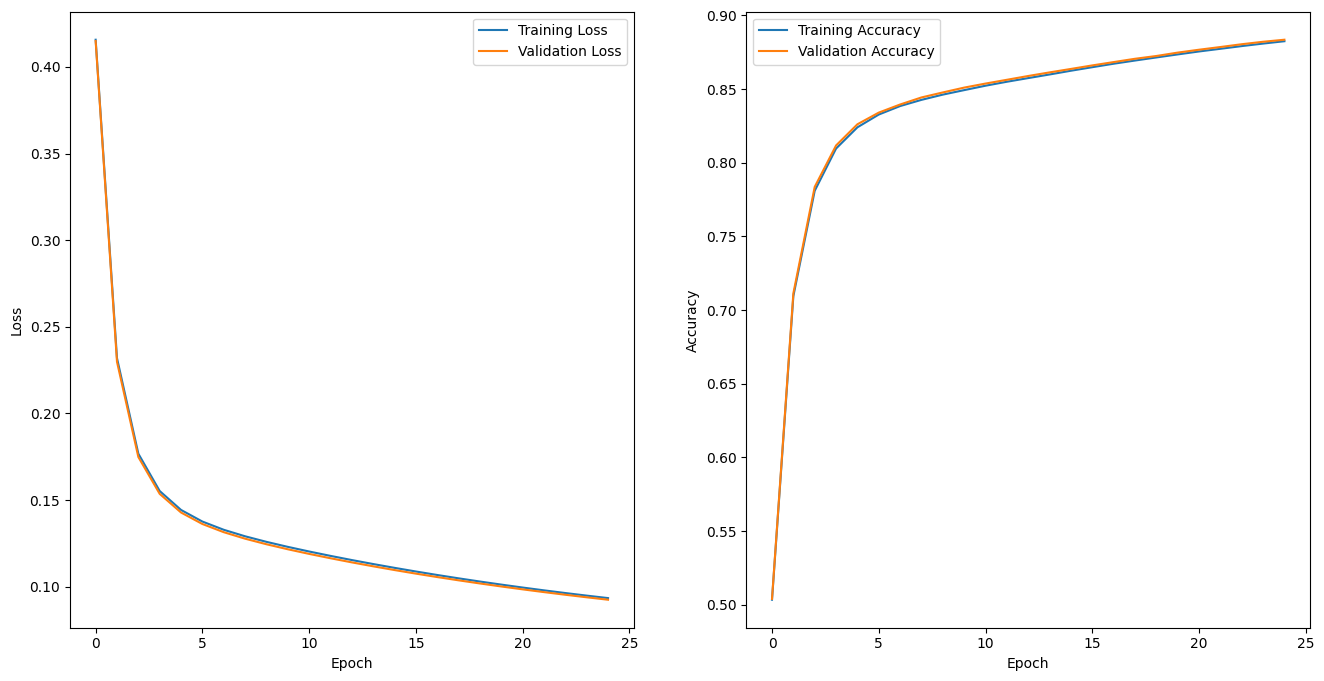

In [13]:
# Training
model = FeedForwardNet(784, 128, 10)
history = model.train(Xtr, Ytr, Xte, Yte, epochs=25)

# Plotting
plot_history(history, accu=True)

#### **Autoencoder**

In [32]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),  
            nn.Tanh()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(128, 28 * 28),  
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
# Training
model_ae = Autoencoder()
loss = nn.MSELoss()
optimizer = torch.optim.SGD(model_ae.parameters(), lr=1e-3)
epochs = 1
batch_size = 16
history = {
    "loss": [],
    "val_loss": [],
}

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in tqdm(range(0, Xtr.shape[0], batch_size)):
        x_batch = torch.from_numpy(Xtr[i : i + batch_size]).float()
        y_batch = torch.from_numpy(Xtr[i : i + batch_size]).float()
        x_enc = model_ae.encoder(x_batch)
        x_rec = model_ae.decoder(x_enc)
        loss_val = loss(x_rec, y_batch)
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
    x_enc = model_ae.encoder(torch.from_numpy(Xtr).float())
    x_rec = model_ae.decoder(x_enc)
    x_val_enc = model_ae.encoder(torch.from_numpy(Xte).float())
    x_val_rec = model_ae.decoder(x_val_enc)
    history["loss"].append(loss(x_rec, torch.from_numpy(Xtr).float()).item())
    history["val_loss"].append(loss(x_val_rec, torch.from_numpy(Xte).float()).item())

# Plotting
plot_history(history)

# Plotting
x_enc = model_ae.encoder(torch.from_numpy(Xte).float()).detach().numpy()
x_rec = model_ae.decoder(torch.from_numpy(x_enc).float()).detach().numpy()
plot_images(Xte, x_rec)

#### **MLP with Sigmoid, MSE**

In [38]:
class MultiLayerPerceptron3(nn.Module):
    def __init__(self):
        super(MultiLayerPerceptron3, self).__init__()
        self.h = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.Sigmoid(),
        )
        self.o = nn.Sequential(
            nn.Linear(128, 10),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.h(x)
        x = self.o(x)
        return x

In [ ]:
# Training
model_3 = MultiLayerPerceptron3()
loss = nn.MSELoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=1e-3)
epochs = 25
batch_size = 16
history = {
    "loss": [],
    "val_loss": [],
    "accuracy": [],
    "val_accuracy": [],
}

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in tqdm(range(0, Xtr.shape[0], batch_size)):
        x_batch = torch.from_numpy(Xtr[i : i + batch_size]).float()
        y_batch = torch.from_numpy(Xtr[i : i + batch_size]).float()
        y_hat = model_3(x_batch)
        loss_val = loss(y_hat, y_batch)
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
    y_hat = model_3(torch.from_numpy(Xtr).float())
    y_val_hat = model_3(torch.from_numpy(Xte).float())
    history["loss"].append(loss(y_hat, torch.from_numpy(Xtr).float()).item())
    history["val_loss"].append(loss(y_val_hat, torch.from_numpy(Xte).float()).item())
    history["accuracy"].append(
        np.sum(Ytr == (y_hat.detach().numpy() > 0.5)) / Ytr.size
    )
    history["val_accuracy"].append(
        np.sum(Yte == (y_val_hat.detach().numpy() > 0.5)) / Yte.size
    )

# Plotting
plot_history(history, accu=True)

In [ ]:
class MultiLayerPerceptron4(nn.Module):
    def __init__(self):
        super(MultiLayerPerceptron4, self).__init__()
        self.h = model_ae.encoder
        self.h[0].weight.requires_grad = False
        self.o = nn.Sequential(
            nn.Linear(128, 10),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.h(x)
        x = self.o(x)
        return x

In [ ]:
# Training
model_4 = MultiLayerPerceptron4()
loss = nn.MSELoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=1e-3, momentum=0.9)
epochs = 25
batch_size = 16
history = {
    "loss": [],
    "val_loss": [],
    "accuracy": [],
    "val_accuracy": [],
}

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in tqdm(range(0, Xtr.shape[0], batch_size)):
        x_batch = torch.from_numpy(Xtr[i : i + batch_size]).float()
        y_batch = torch.from_numpy(Xtr[i : i + batch_size]).float()
        y_hat = model_4(x_batch)
        loss_val = loss(y_hat, y_batch)
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
    y_hat = model_4(torch.from_numpy(Xtr).float())
    y_val_hat = model_4(torch.from_numpy(Xte).float())
    history["loss"].append(loss(y_hat, torch.from_numpy(Xtr).float()).item())
    history["val_loss"].append(loss(y_val_hat, torch.from_numpy(Xte).float()).item())
    history["accuracy"].append(
        np.sum(Ytr == (y_hat.detach().numpy() > 0.5)) / Ytr.size
    )
    history["val_accuracy"].append(
        np.sum(Yte == (y_val_hat.detach().numpy() > 0.5)) / Yte.size
    )

# Plotting
plot_history(history, accu=True)

#### **LeNet**

In [56]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.c1 = nn.Conv2d(1, 6, 5)
        self.s2 = nn.MaxPool2d(2)
        self.c3 = nn.Conv2d(6, 16, 5)
        self.s4 = nn.MaxPool2d(2)
        self.c5 = nn.Linear(16 * 4 * 4, 120)
        self.f6 = nn.Linear(120, 84)
        self.output = nn.Linear(84, 10)

    def forward(self, x):
        x = self.c1(x)
        x = torch.tanh(x)
        x = self.s2(x)
        x = self.c3(x)
        x = torch.tanh(x)
        x = self.s4(x)
        x = x.view(-1, 16 * 4 * 4)
        x = self.c5(x)
        x = torch.tanh(x)
        x = self.f6(x)
        x = torch.tanh(x)
        x = self.output(x)
        return x

In [ ]:
# Training
model = LeNet()
loss = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
epochs = 25
batch_size = 16
history = {
    "loss": [],
    "val_loss": [],
    "accuracy": [],
    "val_accuracy": [],
}

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    for i in tqdm(range(0, Xtr.shape[0], batch_size)):
        x_batch = torch.from_numpy(Xtr[i : i + batch_size]).float().reshape(-1, 1, 28, 28)
        y_batch = torch.from_numpy(Ytr[i : i + batch_size]).float()
        y_hat = model(x_batch)
        loss_val = loss(y_hat, y_batch)
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
    y_hat = model(torch.from_numpy(Xtr).float().reshape(-1, 1, 28, 28))
    y_val_hat = model(torch.from_numpy(Xte).float().reshape(-1, 1, 28, 28))
    history["loss"].append(loss(y_hat, torch.from_numpy(Ytr).float()).item())
    history["val_loss"].append(loss(y_val_hat, torch.from_numpy(Yte).float()).item())
    history["accuracy"].append(
        np.sum(Ytr == (y_hat.detach().numpy() > 0.5)) / Ytr.size
    )
    history["val_accuracy"].append(
        np.sum(Yte == (y_val_hat.detach().numpy() > 0.5)) / Yte.size
    )

# Plotting
plot_history(history, accu=True)

<!-- Implement a 3 layer MLP using PyTorch use sigmoid func;on as 
ac;va;on in all layers and ini;alize the first 2-layers with pretrained 
weights as per the deep belief network using autoencoders then fine 
tune it using MSE and SGD with autograd. Use appropriate learning 
rate or a momentum on weights. Compare the results of the III and IV 
for training vs valida;on losses and accuracies. Plot the train and 
valida;on curves in a single figure. -->